<a href="https://www.kaggle.com/code/testanother/surrender-index?scriptVersionId=117487363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-big-data-bowl-2022/players.csv
/kaggle/input/nfl-big-data-bowl-2022/PFFScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2019.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2020.csv
/kaggle/input/nfl-big-data-bowl-2022/games.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2018.csv
/kaggle/input/nfl-big-data-bowl-2022/plays.csv


In [2]:
import datetime
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import seaborn as sns

## The Surrender Index

This index is based on the beautiful video made by Jon Bois. [Please watch the video here! It is incredible!](https://www.youtube.com/watch?v=F9H9LwGmc-0&t=390s)

So lets get the specifics! There are 4 factors that one needs to get to calculate the index

1. Field Position: 1 if inside 40 yard. Then increases every 20% for every yard past own 40
2. First Down distance: 1 if it is 4th and 1, 0.8  if 4th and 2-3.... 4th & 10+ will be 10+
3. Score differential: 1 if winning, 2 if tied, 3 if losing by 2+ scores, 4 if losing by 1 score
4. Time remaining: 1 if leading or its before halftime (((0.001t)^3)+1) where t = number of seconds since halftime if losing AND it’s after halftime)

In [3]:
df_games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/games.csv')
df_plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2022/plays.csv')
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19979 entries, 0 to 19978
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  19979 non-null  int64  
 1   playId                  19979 non-null  int64  
 2   playDescription         19979 non-null  object 
 3   quarter                 19979 non-null  int64  
 4   down                    19979 non-null  int64  
 5   yardsToGo               19979 non-null  int64  
 6   possessionTeam          19979 non-null  object 
 7   specialTeamsPlayType    19979 non-null  object 
 8   specialTeamsResult      19979 non-null  object 
 9   kickerId                19878 non-null  float64
 10  returnerId              6938 non-null   object 
 11  kickBlockerId           100 non-null    float64
 12  yardlineSide            19813 non-null  object 
 13  yardlineNumber          19979 non-null  int64  
 14  gameClock               19979 non-null

In [4]:
df_plays.describe()

,gameId,playId,quarter,down,yardsToGo,kickerId,kickBlockerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
count,1.997900e+04,19979.000000,19979.000000,19979.000000,19979.000000,19878.000000,100.000000,19979.000000,1102.000000,19979.000000,19979.000000,16327.000000,5324.000000,19979.000000,19979.000000
mean,2.019114e+09,2037.557886,2.484058,1.707142,3.750288,41354.183821,43612.470000,28.749687,3.918330,12.208669,11.565544,54.744166,15.905522,27.315932,59.637569
std,8.519225e+05,1228.659555,1.109341,1.968283,5.671644,5845.474315,3834.614322,10.790720,8.836318,10.063814,10.006012,15.892992,13.150236,20.556990,23.830840
min,2.018091e+09,35.000000,1.000000,0.000000,0.000000,21213.000000,33131.000000,1.000000,-15.000000,0.000000,0.000000,2.000000,-16.000000,-72.000000,11.000000
25%,2.018120e+09,985.000000,2.000000,0.000000,0.000000,38691.000000,41438.250000,16.000000,0.000000,3.000000,3.000000,43.000000,6.000000,0.000000,45.000000
50%,2.019110e+09,2033.000000,2.000000,0.000000,0.000000,42333.000000,43797.000000,35.000000,9.000000,10.000000,10.000000,55.000000,15.000000,39.000000,59.000000
75%,2.020100e+09,3027.000000,3.000000,4.000000,7.000000,45576.000000,46216.500000,35.000000,10.000000,19.000000,17.000000,70.000000,23.000000,40.000000,75.000000
max,2.021010e+09,5729.000000,5.000000,4.000000,46.000000,53146.000000,52592.000000,50.000000,18.000000,56.000000,59.000000,90.000000,104.000000,82.000000,109.000000


In [5]:
df_punt = df_plays[df_plays['specialTeamsPlayType'] == 'Punt']
df_punt = df_punt[df_punt['down'] == 4]
df_punt.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45
5,2018090600,973,"(14:18) M.Bosher punts 49 yards to PHI 40, Cen...",2,4,19,ATL,Punt,Fair Catch,37267.0,...,NaN,NaN,NaN,0,3,NaN,49.0,NaN,49,21
10,2018090600,1850,"(1:30) C.Johnston punts 58 yards to ATL 11, Ce...",2,4,8,PHI,Punt,Downed,45603.0,...,NaN,NaN,NaN,3,6,NaN,58.0,NaN,58,79
11,2018090600,1989,"(:44) M.Bosher punts 57 yards to PHI 17, Cente...",2,4,8,ATL,Punt,Return,37267.0,...,UNR,PHI 50,12.0,3,6,NaN,57.0,8.0,61,36


In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 20, "display.max_columns", 300,'display.max_colwidth', -1):
        display(df)
display_all(df_punt[['playDescription', 'yardlineSide', 'possessionTeam']])

,playDescription,yardlineSide,possessionTeam
1,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",PHI,PHI
4,"(:33) C.Johnston punts 65 yards to end zone, Center-R.Lovato, Touchback.",PHI,PHI
5,"(14:18) M.Bosher punts 49 yards to PHI 40, Center-J.Overbaugh, fair catch by D.Sproles.",ATL,ATL
10,"(1:30) C.Johnston punts 58 yards to ATL 11, Center-R.Lovato, downed by PHI-A.Maddox.",PHI,PHI
11,"(:44) M.Bosher punts 57 yards to PHI 17, Center-J.Overbaugh. D.Sproles to PHI 25 for 8 yards (B.Poole). PENALTY on PHI-L.Reynolds, Unnecessary Roughness, 12 yards, enforced at PHI 25.",ATL,ATL
...,...,...,...
19957,"(8:17) M.Wishnowsky punts 45 yards to SEA 35, Center-C.Holba. D.Reed to SEA 42 for 7 yards (D.Flannigan-Fowles; M.Cole). PENALTY on SEA-F.Swain, Illegal Block Above the Waist, 10 yards, enforced at SEA 42.",SF,SF
19958,"(6:47) M.Dickson punts 61 yards to SF 16, Center-T.Ott. R.Cracraft to SF 21 for 5 yards (C.Barton).",SEA,SEA
19964,"(8:39) M.Dickson punts 43 yards to SF 30, Center-T.Ott. R.Cracraft to SEA 49 for 21 yards (M.Dickson).",SEA,SEA
19967,"(5:17) M.Dickson punts 52 yards to SF 22, Center-T.Ott. R.Cracraft to SF 27 for 5 yards (N.Bellore).",SEA,SEA


In [7]:
temp = df_punt.copy()

In [8]:
def ff(row):
    if row['possessionTeam'] == row['yardlineSide']:
        return row['yardlineNumber']
    return 50 + (50 - row['yardlineNumber'])
temp['absolute_yard'] = temp.apply(ff, axis=1)

In [9]:
# see https://surrender-index.glitch.me/
# see https://github.com/andrew-shackelford/Surrender-Index/blob/master/Historical%20Surrender%20Indices.ipynb
def calc_field_pos(val):
    if val <= 40:
        return 1
    elif val > 40 and val < 50:
        return pow(1.1, (val - 40))
    elif val == 50:
        return pow(1.1, 10)
    return pow(1.2, (val - 50)) * (pow(1.1, 10))

def yard_discount(yard):
    if yard >= 10:
        return 0.2
    elif yard >= 7:
        return 0.4
    elif yard >= 4:
        return 0.6
    elif yard >= 2:
        return 0.8
    else:
        return 1.0

def score_of_game(game_score):
    if game_score > 0:
        return 1.
    if game_score == 0:
        return 2.
    if game_score < -8.:
        return 3.
    return 4.

def secs_elapsed_after_halftime(q, t):
    # .total_seconds()
    time_str = t
    time_object = datetime.strptime(time_str, '%M:%S:%f').time()
    qt = timedelta(minutes=time_object.minute, seconds=time_object.second)
    timeElapsed = (900 * (q - 1)) + (900 - qt.total_seconds())
    return max(0, timeElapsed - 1800)

def game_clock(quarter, clock, game_score):
    x = secs_elapsed_after_halftime(quarter, clock)
    if x > 0 and game_score < 1:
        return ((x * 0.001) ** 3.) + 1.
    return 1.

def calc_surrender_index(yards, quarter, yard_to_go, clock, home, away, game_id, possessionTeam):
    if game_id in df_games['gameId'].values:
        game_infos = df_games[df_games['gameId'] == game_id]
        home_team = game_infos['homeTeamAbbr']
        away_team = game_infos['visitorTeamAbbr']
        score = 0
        if possessionTeam in home_team.values:
            score = home - away
        else:
            score = away - home
        return calc_field_pos(yards) * yard_discount(yards) * score_of_game(score) * game_clock(quarter, clock, score)
    return 0

<AxesSubplot:xlabel='yy', ylabel='field_pos'>

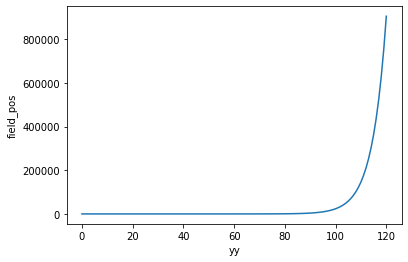

In [10]:
yard_lines = np.arange(121)
test_data = pd.DataFrame(data=yard_lines, columns = ['yy'])
test_data['field_pos'] = test_data.apply(lambda x: calc_field_pos(x['yy']), axis=1)
sns.lineplot(data=test_data, x='yy', y='field_pos')

In [11]:
t = temp.copy()
t['surrender_index'] = t.apply(lambda x: calc_surrender_index(x['absolute_yard'], x['quarter'], x['yardsToGo'], x['gameClock'], x['preSnapHomeScore'], x['preSnapVisitorScore'], x['gameId'], x['possessionTeam']), axis=1)

In [12]:
t.describe()

,gameId,playId,quarter,down,yardsToGo,kickerId,kickBlockerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,absolute_yard,surrender_index
count,5.991000e+03,5991.000000,5991.000000,5991.0,5991.000000,5917.000000,39.00000,5991.000000,641.000000,5991.000000,5991.000000,5878.000000,2355.000000,5991.000000,5991.000000,5991.000000,5991.000000
mean,2.019067e+09,1997.195794,2.450843,4.0,9.092973,41701.975663,43523.74359,32.334836,3.160686,10.797530,10.066934,45.667234,8.574947,40.428476,59.122851,34.123519,1.401033
std,8.426012e+05,1210.152254,1.113678,0.0,5.942563,5790.259030,3819.28707,11.493631,9.257467,9.676257,9.555480,8.971256,10.624420,12.582569,21.058293,13.860337,3.193065
min,2.018091e+09,112.000000,1.000000,4.0,1.000000,29141.000000,33234.00000,1.000000,-15.000000,0.000000,0.000000,2.000000,-13.000000,-45.000000,11.000000,1.000000,0.200000
25%,2.018120e+09,926.500000,1.000000,4.0,5.000000,38600.000000,41470.00000,24.000000,-5.000000,3.000000,0.000000,40.000000,2.000000,35.000000,42.000000,24.000000,0.266200
50%,2.019103e+09,1948.000000,2.000000,4.0,8.000000,42508.000000,43797.00000,33.000000,8.000000,9.000000,7.000000,46.000000,7.000000,41.000000,59.000000,33.000000,0.618575
75%,2.020093e+09,3007.000000,3.000000,4.0,12.000000,46218.000000,46304.00000,42.000000,10.000000,17.000000,16.000000,52.000000,12.000000,48.000000,76.000000,45.000000,1.171280
max,2.021010e+09,5729.000000,5.000000,4.0,46.000000,53146.000000,52565.00000,50.000000,18.000000,54.000000,59.000000,79.000000,99.000000,82.000000,109.000000,70.000000,75.371088


<AxesSubplot:xlabel='gameId', ylabel='surrender_index'>

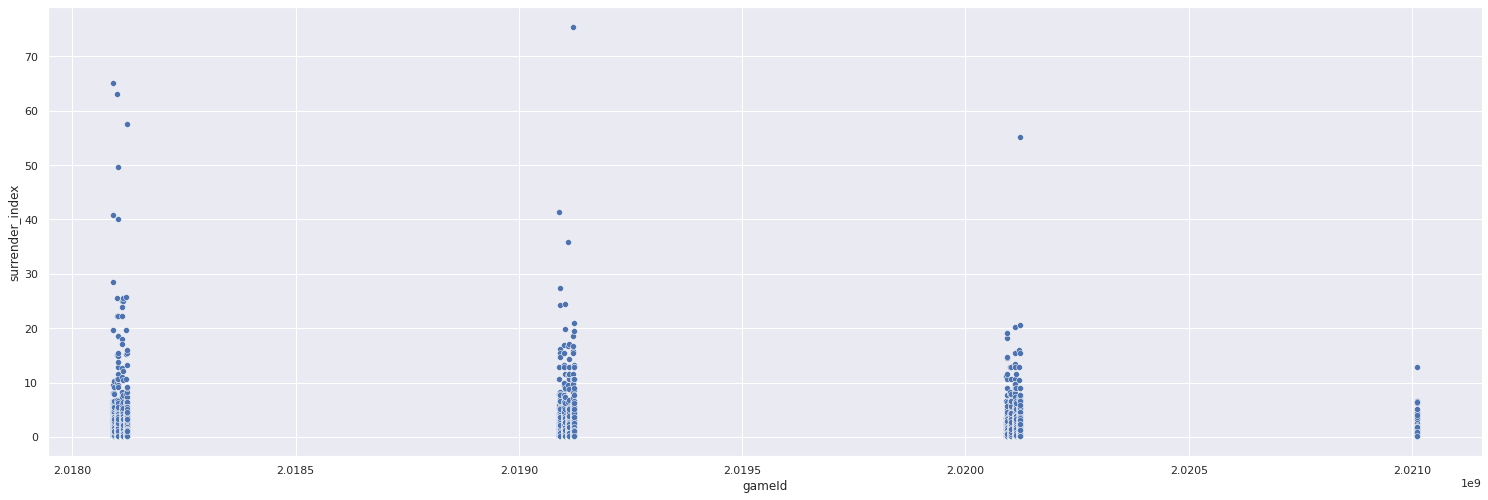

In [13]:
sns.set(rc={'figure.figsize':(25.7,8.27)})
sns.scatterplot(data=t, x="gameId", y="surrender_index")